In [1]:
import sympy as sp

def sub_pow_exprs(expr):
    # replace each square root expression with sqrt(abs()) to avoid negative inside sqrt
    if (isinstance(expr, sp.Number)): return expr
    new_args = []
    for i in range(len(expr.args)):
        new_args.append(sub_pow_exprs(expr.args[i]))
    if expr.args:
        expr = expr.func(*tuple(new_args))
        if expr.func == sp.core.power.Pow and abs(expr.exp) == 0.5:
            expr = sp.sqrt(sp.Abs(expr.base, evaluate=False))
    return expr

x = sp.symbols("x")
y = sp.symbols("y")
expr = 0.5*sp.sqrt(1+sp.sqrt(sp.log(x/y))) * sp.sqrt(x+y) * sp.Abs(y*x)
print(sub_pow_exprs(expr))
print(expr.func)
print(expr.args)
new_expr = expr.func(*tuple(expr.args))
new_expr = sp.sqrt(sp.Abs(expr.base))
print(expr.base)
print(new_expr)
expr = x/y
print(expr.args)
print(expr.args[1].args)

0.5*Abs(x*y)*sqrt(Abs(x + y))*sqrt(Abs(sqrt(Abs(log(x/y))) + 1))
<class 'sympy.core.mul.Mul'>
(0.500000000000000, sqrt(sqrt(log(x/y)) + 1), sqrt(x + y), Abs(x*y))


AttributeError: 'Mul' object has no attribute 'base'

cacti tech node: 0.032, specified cacti transistor size: 7
self.cacti_dat_file: src/cacti/tech_params/32nm.dat
deque([[<src.dfg_algo.Node object at 0x15f3266e0>, 0], [<src.dfg_algo.Node object at 0x15f3265f0>, 0]])
dfg Node 2: __main__, op: None, memory_links: None, compute_id: None 0
None
dfg Node 1: __name__, op: Regs, memory_links: None, compute_id: None 0
Regs
dfg Node 3: ==, op: Eq, memory_links: None, compute_id: None 1
Eq
dfg Node 3: ==, op: Eq, memory_links: None, compute_id: None 1
deque([[<src.dfg_algo.Node object at 0x15f326d10>, 0]])
dfg Node 5: main(), op: None, memory_links: None, compute_id: None 0
None
deque([[<src.dfg_algo.Node object at 0x15f327880>, 0], [<src.dfg_algo.Node object at 0x15f327790>, 0]])
dfg Node 9: 3, op: None, memory_links: None, compute_id: None 0
None
dfg Node 7: 2, op: None, memory_links: None, compute_id: None 0
None
dfg Node 10: b_1, op: Regs, memory_links: None, compute_id: None 1
Regs
dfg Node 8: a_1, op: Regs, memory_links: None, compute_id: N

/Users/PatrickMcEwen/miniforge3/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

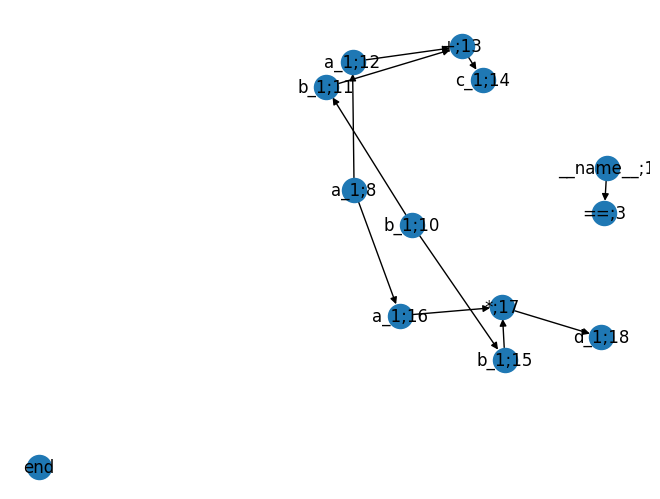

In [1]:
import os
os.chdir("/Users/PatrickMcEwen/git_container/codesign")
import networkx as nx
from src import hardwareModel
from src import architecture_search
from src.sim_util import find_upstream_node_in_graph

benchmark = "src/benchmarks/models/add_and_mult.py"
config = "aladdin_const_with_mem"
sim, hw, computation_dfg = architecture_search.setup_arch_search(benchmark, config, gen_cacti=False)
hardwareModel.un_allocate_all_in_use_elements(hw.netlist)

def prune_buffer_and_mem_nodes(computation_graph: nx.DiGraph, hw_netlist: nx.DiGraph, sdc_schedule: bool = False):
    """
    Call after allocation to remove unnecessary buffer and memory nodes.
    Removes memory nodes when the data is already in the buffer.
    Removes buffer nodes when the data is already in the registers.
    """
    def check_buffer_reg_hit(reg_node):
        buf_in = find_upstream_node_in_graph(computation_graph, "Buf", reg_node[0]) 
        mem_in = find_upstream_node_in_graph(computation_graph, "MainMem", buf_in[0])
        print(hw_netlist.nodes[mem_in[1]["allocation"]]["memory_module"].locations)
        allocated_reg = reg_node[1]["allocation"]
        allocated_reg_data = hw_netlist.nodes[allocated_reg]
        var_name = reg_node[0].split(";")[0]
        print(allocated_reg_data["var"], var_name)
        if allocated_reg_data["var"] == var_name:
            # remove the buffer and memory nodes
            computation_graph.remove_node(buf_in[0])
            computation_graph.remove_node(mem_in[0])
        elif hw_netlist.nodes[buf_in[1]["allocation"]]["memory_module"].find(var_name):
            # remove the memory node
            computation_graph.remove_node(mem_in[0])
            size = hw_netlist.nodes[buf_in[1]["allocation"]]["memory_module"].read(var_name)
            computation_graph.nodes[buf_in[0]]["size"] = size
            computation_graph.nodes[reg_node[0]]["size"] = size
        else:
            # read from memory and add to cache
            size = -1*hw_netlist.nodes[mem_in[1]["allocation"]]["memory_module"].read(var_name)
            computation_graph.nodes[mem_in[0]]["size"] = size
            computation_graph.nodes[buf_in[0]]["size"] = size
            computation_graph.nodes[reg_node[0]]["size"] = size
        hw_netlist.nodes[allocated_reg]["var"] = var_name
    print("starting pruning process")
    layer = 0
    if sdc_schedule:
        regs_sorted = sorted(list(filter(lambda x: x[1]["function"] == "Regs", computation_graph.nodes.data())), key=lambda x: x[1]["start_time"])
        print(regs_sorted)
        for reg_node in regs_sorted:
            check_buffer_reg_hit(reg_node)
    else:
        gen = list(filter(lambda x: x[1]["layer"] == layer, computation_graph.nodes.data()))
        print(gen)
        while len(gen) != 0:
            reg_nodes = list(filter(lambda x: x[1]["function"] == "Regs", gen))
            for reg_node in reg_nodes:
                check_buffer_reg_hit(reg_node)
            layer += 1
            gen = list(
                filter(lambda x: x[1]["layer"] == layer, computation_graph.nodes.data())
            )
            print(gen)
    return computation_graph

scheduled_dfg = sim.schedule(computation_dfg, hw, "sdc", prune_func=prune_buffer_and_mem_nodes)

#nx.draw(scheduled_dfg, with_labels=True)



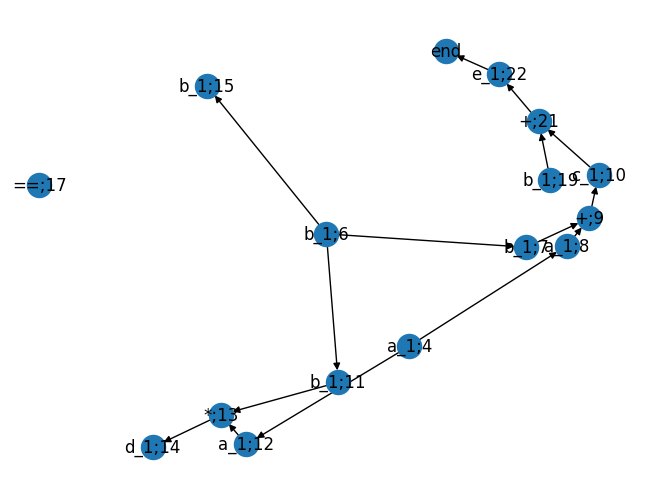

In [1]:
import os
os.chdir("/Users/PatrickMcEwen/git_container/codesign")
import networkx as nx
from src import sim_util
log_dir = sim_util.get_latest_log_dir()

G = nx.read_gml(log_dir + "/computation_dfg_0.gml")
nx.draw(G, with_labels=True)

In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory


In [ ]:
model = pyo.ConcreteModel()
model.nVars = pyo.Param(initialize=4)
model.N = pyo.RangeSet(model.nVars)
model.x = pyo.Var(model.N, domain=pyo.NonNegativeReals)
model.obj = pyo.Objective(expr=1/model.x[2], sense=pyo.minimize)
model.scaling_factor = pyo.Suffix(direction=pyo.Suffix.EXPORT)
print(model.obj.polynomial_degree())
for i in range(1, 5):
    model.x[i] = 1
    model.scaling_factor[model.x[i]] = None
model.scaling_factor[model.obj] = 1
sub_expr = model.x[3]
for i in range(1, 256):
    sub_expr = abs(sub_expr + 5 + model.x[4]*model.x[1])
model.constr = pyo.Constraint(expr=model.x[1] == model.x[2])
opt = SolverFactory("ipopt")
model.display()
scaled_model = pyo.TransformationFactory("core.scale_model").create_using(model)
scaled_model.display()
#results = opt.solve(model)
#model.display()

None
Model unknown

  Variables:
    x : Size=4, Index=N
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     1 :  None : False : False : NonNegativeReals
          2 :     0 :     1 :  None : False : False : NonNegativeReals
          3 :     0 :     1 :  None : False : False : NonNegativeReals
          4 :     0 :     1 :  None : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   1.0

  Constraints:
    constr : Size=1
        Key  : Lower : Body : Upper
        None :   0.0 :    0 :   0.0
Model unknown

  Variables:
    scaled_x : Size=4, Index=N
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :     2 :  None : False : False : NonNegativeReals
          2 :     0 :     2 :  None : False : False : NonNegativeReals
          3 :     0 :     2 :  None : False : False : NonNegativeReals
          4 :     0 :     2 :  None : Fa

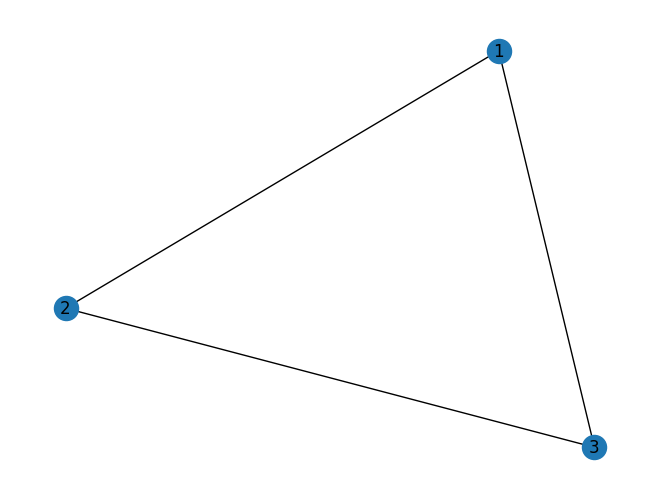

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (2, 3)])

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
import sympy as sp

class expr:
    def __init__(self, sp_expr):
        self.sp_expr = sp_expr
    def __mul__(self, other):
        if not isinstance(other, expr):
            return expr((self.sp_expr * other).expand())
        return expr((self.sp_expr * other.sp_expr).expand())
    
    def __add__(self, other):
        if not isinstance(other, expr):
            return expr(self.sp_expr + other)
        return expr(self.sp_expr + other.sp_expr)
    
    def __floordiv__(self, other):
        if not isinstance(other, expr):
            return expr(self.sp_expr // other)
        return expr(self.sp_expr // other.sp_expr)
    
    def __truediv__(self, other):
        if not isinstance(other, expr):
            return expr(self.sp_expr / other)
        return expr(self.sp_expr / other.sp_expr)
    
a = sp.symbols("a")
b = sp.symbols("b")
c = sp.symbols("c")
# non-expanded expression
print(a*(b+c)/2)

# expr class automatically expands expressions upon multiply
d = expr(a)*(b+c) / 2
print(d.sp_expr)

a*(b + c)/2
a*b/2 + a*c/2


In [ ]:
import sympy as sp

x = sp.symbols("x")
y = sp.symbols("y")
z = sp.symbols("z")
w = sp.symbols("w")

exprs_to_sub_s = []
symbol_idx = 0

expr = x * y * z * w - 1
print(expr.args[0])
print(isinstance(expr.args[0], sp.Number))
args = list(expr.args)
print(args)
print(expr.func == sp.Mul)
if (expr.func == sp.Mul and len(expr.args) > 2):
    first_arg = expr.args[0]
    for i in range(1, len(expr.args)-1):
        sub_expr = expr.func(*((first_arg, expr.args[i])))
        sub_symbol = sp.symbols(f"sub_var_{symbol_idx}")
        symbol_idx += 1
        exprs_to_sub_s.append([sub_expr, sub_symbol])
        first_arg = sub_symbol
    expr = expr.func(*((first_arg, expr.args[-1])))
new_symbol = sp.symbols(f"sub_var_{symbol_idx}")
symbol_idx += 1
exprs_to_sub_s.append([expr, new_symbol])

print(exprs_to_sub_s)

subs = {x: 1, y:2}

new_expr = expr.func(*(tuple(args)))
print(new_expr)



-1
True
[-1, w*x*y*z]
False
[[w*x*y*z - 1, sub_var_0]]
w*x*y*z - 1


In [ ]:
import sympy as sp

m = {}

v = sp.symbols("v")
d = sp.symbols("d")
m[v*d] = 1
print(m[v*d])
print(type(v*d))

1
<class 'sympy.core.mul.Mul'>


In [ ]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import sympy

import sympy2jax

def assert_equal(x, y):
    x_leaves, x_tree = jtu.tree_flatten(x)
    y_leaves, y_tree = jtu.tree_flatten(y)
    assert x_tree == y_tree
    for xi, yi in zip(x_leaves, y_leaves):
        assert type(xi) is type(yi)
        if isinstance(xi, jnp.ndarray):
            assert xi.shape == yi.shape
            assert xi.dtype == yi.dtype
            assert jnp.all(xi == yi)
        else:
            assert xi == yi

def assert_sympy_allclose(x, y):
    assert isinstance(x, sympy.Expr)
    assert isinstance(y, sympy.Expr)
    assert x.func is y.func
    if isinstance(x, sympy.Float):
        assert abs(float(x) - float(y)) < 1e-5
    elif isinstance(x, sympy.Integer):
        assert x == y
    elif isinstance(x, sympy.Rational):
        assert x.numerator == y.numerator  # pyright: ignore
        assert x.denominator == y.denominator  # pyright: ignore
    elif isinstance(x, sympy.Symbol):
        assert x.name == y.name  # pyright: ignore
    else:
        assert len(x.args) == len(y.args)
        for xarg, yarg in zip(x.args, y.args):
            assert_sympy_allclose(xarg, yarg)

x_sym = sympy.symbols("x_sym")
y = 2.1 * x_sym**2
mod = sympy2jax.SymbolicModule(y)
x = jnp.array(1.1)

grad_m = eqx.filter_grad(lambda m, z: m(x_sym=z))(mod, x)
#print(grad_m)
grad_z = eqx.filter_grad(lambda z, m: m(x_sym=z))(x, mod)

true_grad_m = eqx.filter(
    sympy2jax.SymbolicModule(1.21 * x_sym**2), eqx.is_inexact_array
)
true_grad_z = jnp.array(4.2 * x)
print(grad_z)

assert_equal(grad_m, true_grad_m)
assert_equal(grad_z, true_grad_z)

mod2 = eqx.apply_updates(mod, grad_m)
expr = mod2.sympy()

assert_sympy_allclose(expr, 3.31 * x_sym**2)

R = sympy.symbols("R")
C = sympy.symbols("C")
edp = R*C + 2*C**2
mod = sympy2jax.SymbolicModule(edp)
R_i = jnp.array(2.0)
A_i = jnp.array(2.0)
C_i = jnp.array(3.0)
grad_C = eqx.filter_grad(lambda z, y, m: m(C=z, R=y))(C_i, R_i, mod)
print(grad_C)
grad_R = eqx.filter_grad(lambda a, z, y, m: m(A=z, R=a, C=y))(R_i, A_i, C_i, mod)
print(grad_R)

In [ ]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import sympy
import hw_symbols
import sympy2jax
from codesign import Codesign
import copy


def rotate_arr(args_arr):
    next_val = args_arr[0]
    for i in range(len(args_arr))[::-1]:    
        tmp = next_val
        next_val = args_arr[(i)%len(args_arr)]
        args_arr[(i)%len(args_arr)] = tmp
    return args_arr

def get_grad(grad_var, args_arr, jmod):
    return eqx.filter_grad(lambda gvar, arr0, arr, a: a(grad_var = gvar,
                                                V_dd=arr0,
                                                f=arr[1],
                                                MemReadL=arr[2],
                                                MemWriteL=arr[3],
                                                MemReadPact=arr[4],
                                                MemWritePact=arr[5],
                                                MemPpass=arr[6],
                                                Reff_And=arr[7],
                                                Reff_Or=arr[8],
                                                Reff_Add=arr[9],
                                                Reff_Sub=arr[10],
                                                Reff_Mult=arr[11],
                                                Reff_FloorDiv=arr[12],
                                                Reff_Mod=arr[13],
                                                Reff_LShift=arr[14],
                                                Reff_RShift=arr[15],
                                                Reff_BitOr=arr[16],
                                                Reff_BitXor=arr[17],
                                                Reff_BitAnd=arr[18],
                                                Reff_Eq=arr[19],
                                                Reff_NotEq=arr[20],
                                                Reff_Lt=arr[21],
                                                Reff_LtE=arr[22],
                                                Reff_Gt=arr[23],
                                                Reff_GtE=arr[24],
                                                Reff_USub=arr[25],
                                                Reff_UAdd=arr[26],
                                                Reff_IsNot=arr[27],
                                                Reff_Not=arr[28],
                                                Reff_Invert=arr[29],
                                                Reff_Regs=arr[30],
                                                Ceff_And=arr[31],
                                                Ceff_Or=arr[32],
                                                Ceff_Add=arr[33],
                                                Ceff_Sub=arr[34],
                                                Ceff_Mult=arr[35],
                                                Ceff_FloorDiv=arr[36],
                                                Ceff_Mod=arr[37],
                                                Ceff_LShift=arr[38],
                                                Ceff_RShift=arr[39],
                                                Ceff_BitOr=arr[40],
                                                Ceff_BitXor=arr[41],
                                                Ceff_BitAnd=arr[42],
                                                Ceff_Eq=arr[43],
                                                Ceff_NotEq=arr[44],
                                                Ceff_Lt=arr[45],
                                                Ceff_LtE=arr[46],
                                                Ceff_Gt=arr[47],
                                                Ceff_GtE=arr[48],
                                                Ceff_USub=arr[49],
                                                Ceff_UAdd=arr[50],
                                                Ceff_IsNot=arr[51],
                                                Ceff_Not=arr[52],
                                                Ceff_Invert=arr[53],
                                                Ceff_Regs=arr[54]))(grad_var, args_arr[0], args_arr, jmod)

mod = Codesign("testme.py", "logs")
edp = 2*hw_symbols.symbol_table["Ceff_Add"] + 4*hw_symbols.symbol_table["Ceff_Regs"] + 3*hw_symbols.symbol_table["V_dd"]
#print(edp)
args_arr = []
starting_vals = []
for name in hw_symbols.symbol_table:
    args_arr.append(jnp.array(mod.tech_params[hw_symbols.symbol_table[name]]))
    starting_vals.append(mod.tech_params[hw_symbols.symbol_table[name]])
original_arr = copy.deepcopy(args_arr)

#print(args_arr)
grad_map = {}
grad_var = sympy.symbols("grad_var")
j = 0
for name in hw_symbols.symbol_table:
    m = {}
    i = 0
    for other_name in hw_symbols.symbol_table:
        m[hw_symbols.symbol_table[other_name]] = list(hw_symbols.symbol_table)[(i+j)%len(hw_symbols.symbol_table)]
        i += 1
    edp_cur = edp.subs({
        hw_symbols.symbol_table[name]: grad_var
    })
    print(edp_cur)
    jmod = sympy2jax.SymbolicModule(edp_cur)
    grad_map[name] = get_grad(args_arr[j], args_arr, jmod)
    print(name, grad_map[name])
    print(args_arr)
    j += 1
    #raise Exception()
raise Exception()

memory needed: 116 bytes
nvm memory needed: 0 bytes
memory needed: 116 bytes
nvm memory needed: 0 bytes
2*Ceff_Add + 4*Ceff_Regs + 3*grad_var
V_dd 3.0
[Array(1.1, dtype=float32, weak_type=True), Array(2.e+09, dtype=float32, weak_type=True), Array(2.e-09, dtype=float32, weak_type=True), Array(2.e-09, dtype=float32, weak_type=True), Array(1.e-07, dtype=float32, weak_type=True), Array(1.e-07, dtype=float32, weak_type=True), Array(8.448e-08, dtype=float32, weak_type=True), Array(2010.4232, dtype=float32, weak_type=True), Array(2010.4232, dtype=float32, weak_type=True), Array(2004.8353, dtype=float32, weak_type=True), Array(2004.8353, dtype=float32, weak_type=True), Array(46.949585, dtype=float32, weak_type=True), Array(46.949585, dtype=float32, weak_type=True), Array(2004.8353, dtype=float32, weak_type=True), Array(1014.97614, dtype=float32, weak_type=True), Array(1014.97614, dtype=float32, weak_type=True), Array(2010.4232, dtype=float32, weak_type=True), Array(2010.4232, dtype=float32, we

Exception: 

In [ ]:
import pandas as pd

# For now, only reading from asap7 data
# Will update in the future with more
f = open("tech_node_data/asap7data.txt", "r")
fl = f.readlines()
d = []
name = []
technode = []
for i in range(len(fl)):
    if fl[i].startswith("cell") and len(fl[i+2])>1:
        name.append(fl[i][fl[i].find("(")+1:fl[i].find("_")])
        technode.append(7)
        n = name[-1]
        d.append([float(fl[i+1].split(" ")[1])*1e-6, float(fl[i+5].split(" ")[1])*1e-15, float(fl[i+6].split(" ")[1])])
ind = pd.MultiIndex.from_arrays([technode, name], names=("tech node", "standard cell"))
df = pd.DataFrame(data=d, index=ind, columns=["area", "R_eff", "C_eff"])
df.to_csv("params/std_cell_data.csv")

In [ ]:

import yaml
import os
import sys
from src import sim_util
import glob
import datetime

%load_ext autoreload
%autoreload 2

def get_latest_log_dir():
    log_dirs = glob.glob("../logs/*-*-*_*-*-*")
    log_dirs = sorted(log_dirs, key=lambda x: datetime.datetime.strptime(x.split("/")[-1], "%Y-%m-%d_%H-%M-%S"))
    return log_dirs[-1]

log_dir = get_latest_log_dir()

print(log_dir)

log_file = open(f"{log_dir}/log.txt", 'r')
log_lines = log_file.readlines()
for line in log_lines:
    if line.startswith("INFO:src.hardwareModel:BUFFER") or line.startswith("INFO:src.hardwareModel:MEMORY"):
        print(line)

rcs = yaml.load(open(f"logs/{log_date}/rcs_0.yaml", 'r'), loader=yaml.Loader)
tech_params = sim_util.generate_init_params_from_rcs_as_symbols(rcs)
cacti_exprs = yaml.load(open(f"logs/{log_date}/cacti_exprs_0.yaml", 'r'), loader=yaml.Loader)
for i in range(len(cacti_exprs)):
    cacti_exprs[i] = cacti_exprs[i].xreplace(tech_params)
print(cacti_exprs)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IndexError: list index out of range